In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

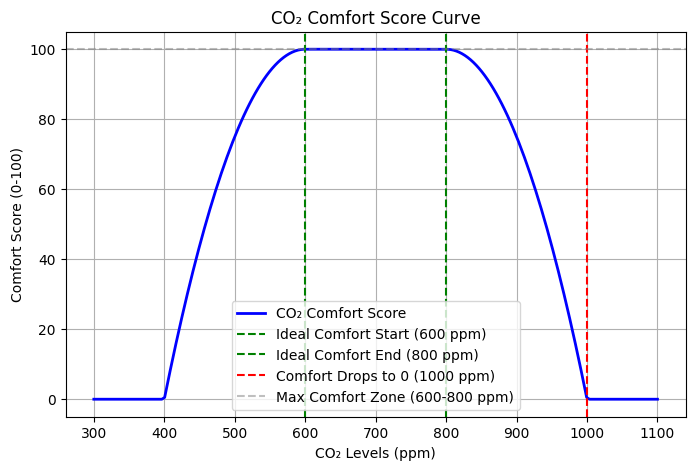

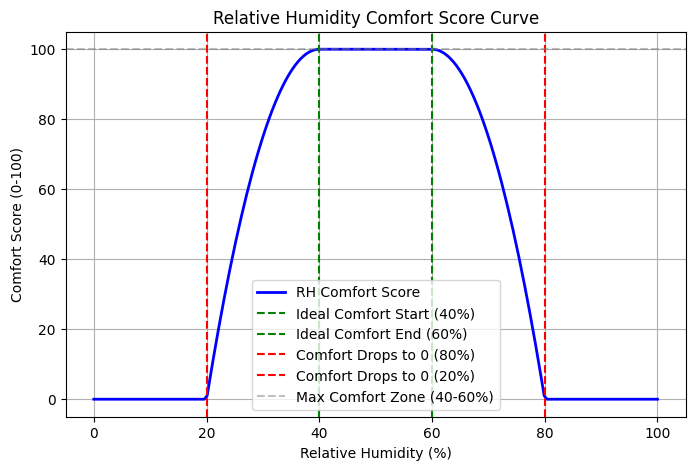

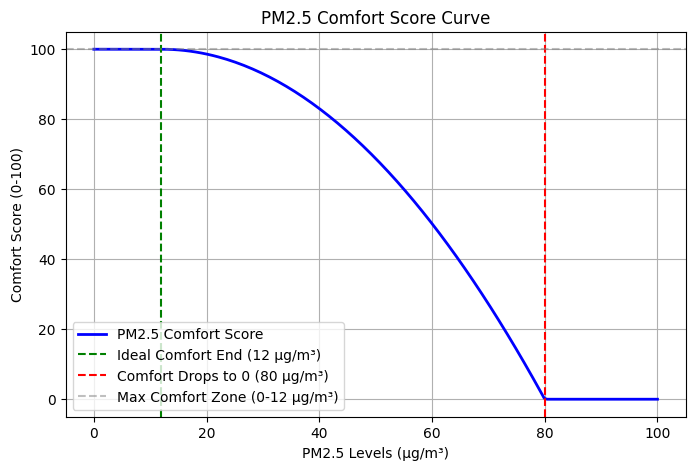

In [134]:
dfs = [pd.read_csv('datasets/madalena_merged/E145.csv'), pd.read_csv('datasets/madalena_merged/E146.csv'),pd.read_csv('datasets/madalena_merged/E147.csv'),pd.read_csv('datasets/madalena_merged/E148.csv'),]

def temperature_calc(temp):
    if temp <= 16 or temp >= 30:
        return 0
    elif 22 <= temp <= 24:
        return 100
    elif 16 < temp < 22:
        return 100 - ((temp - 22) / (22 - 16))**2 * 100  
    elif 24 < temp < 30:
        return 100 - ((temp - 24) / (30 - 24))**2 * 100 

def co2_comfort_score(co2):
    if co2 <= 400 or co2 >= 1000:
        return 0
    elif 600 <= co2 <= 800:
        return 100
    elif 400 < co2 < 600:
        return 100 - ((co2 - 600) / (600 - 400))**2 * 100 
    elif 800 < co2 < 1000:
        return 100 - ((co2 - 800) / (1000 - 800))**2 * 100  

co2_levels_fixed = np.linspace(300, 1100, 200)  
co2_scores_fixed = [co2_comfort_score(co2) for co2 in co2_levels_fixed]

plt.figure(figsize=(8, 5))
plt.plot(co2_levels_fixed, co2_scores_fixed, label="CO₂ Comfort Score", color="blue", linewidth=2)
plt.axvline(x=600, linestyle="--", color="green", label="Ideal Comfort Start (600 ppm)")
plt.axvline(x=800, linestyle="--", color="green", label="Ideal Comfort End (800 ppm)")
plt.axvline(x=1000, linestyle="--", color="red", label="Comfort Drops to 0 (1000 ppm)")
plt.axhline(y=100, linestyle="--", color="gray", alpha=0.5, label="Max Comfort Zone (600-800 ppm)")
plt.xlabel("CO₂ Levels (ppm)")
plt.ylabel("Comfort Score (0-100)")
plt.title("CO₂ Comfort Score Curve")
plt.legend()
plt.grid(True)

plt.show()

def rh_comfort_score(rh):
    if rh <= 20 or rh >= 80:
        return 0
    elif 40 <= rh <= 60:
        return 100
    elif 20 < rh < 40:
        return 100 - ((rh - 40) / (40 - 20))**2 * 100  
    elif 60 < rh < 80:
        return 100 - ((rh - 60) / (80 - 60))**2 * 100  

rh_levels = np.linspace(0, 100, 200)  
rh_scores = [rh_comfort_score(rh) for rh in rh_levels]


plt.figure(figsize=(8, 5))
plt.plot(rh_levels, rh_scores, label="RH Comfort Score", color="blue", linewidth=2)
plt.axvline(x=40, linestyle="--", color="green", label="Ideal Comfort Start (40%)")
plt.axvline(x=60, linestyle="--", color="green", label="Ideal Comfort End (60%)")
plt.axvline(x=80, linestyle="--", color="red", label="Comfort Drops to 0 (80%)")
plt.axvline(x=20, linestyle="--", color="red", label="Comfort Drops to 0 (20%)")
plt.axhline(y=100, linestyle="--", color="gray", alpha=0.5, label="Max Comfort Zone (40-60%)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Comfort Score (0-100)")
plt.title("Relative Humidity Comfort Score Curve")
plt.legend()
plt.grid(True)

plt.show()

def pm25_comfort_score(pm25):
    if pm25 >= 80:
        return 0
    elif pm25 <= 12:
        return 100
    else:
        return 100 - ((pm25 - 12) / (80 - 12))**2 * 100  

pm25_levels_fixed = np.linspace(0, 100, 200)  
pm25_scores_fixed = [pm25_comfort_score(pm25) for pm25 in pm25_levels_fixed]


plt.figure(figsize=(8, 5))
plt.plot(pm25_levels_fixed, pm25_scores_fixed, label="PM2.5 Comfort Score", color="blue", linewidth=2)
plt.axvline(x=12, linestyle="--", color="green", label="Ideal Comfort End (12 µg/m³)")
plt.axvline(x=80, linestyle="--", color="red", label="Comfort Drops to 0 (80 µg/m³)")
plt.axhline(y=100, linestyle="--", color="gray", alpha=0.5, label="Max Comfort Zone (0-12 µg/m³)")
plt.xlabel("PM2.5 Levels (µg/m³)")
plt.ylabel("Comfort Score (0-100)")
plt.title("PM2.5 Comfort Score Curve")
plt.legend()
plt.grid(True)

plt.show()


In [135]:
def calculate_overall_comfort(df):
    df['Temp_Score'] = df['T_in[°C]'].apply(temperature_calc)
    df['RH_Score'] = df['RH [%]'].apply(rh_comfort_score)
    df['CO2_Score'] = df['CO2[ppm]'].apply(co2_comfort_score)
    df['PM2.5_Score'] = df['PM2_5[ug/m3]'].apply(pm25_comfort_score)
    
    df['Thermal_Comfort'] = (df['Temp_Score'] + df['RH_Score']) / 2
    df['IAQ_Score'] = (df['CO2_Score'] + df['PM2.5_Score']) / 2
    
    df['Overall_Comfort'] = 0.5 * df['Thermal_Comfort'] + 0.5 * df['IAQ_Score']
    df.drop(columns=['Temp_Score', 'RH_Score', 'CO2_Score', 'PM2.5_Score', 'Thermal_Comfort', 'IAQ_Score'], inplace=True)

    return df
for index, df in enumerate(dfs):
    dfs[index] = calculate_overall_comfort(df)

In [28]:
dfs[0].shape

(2749, 13)

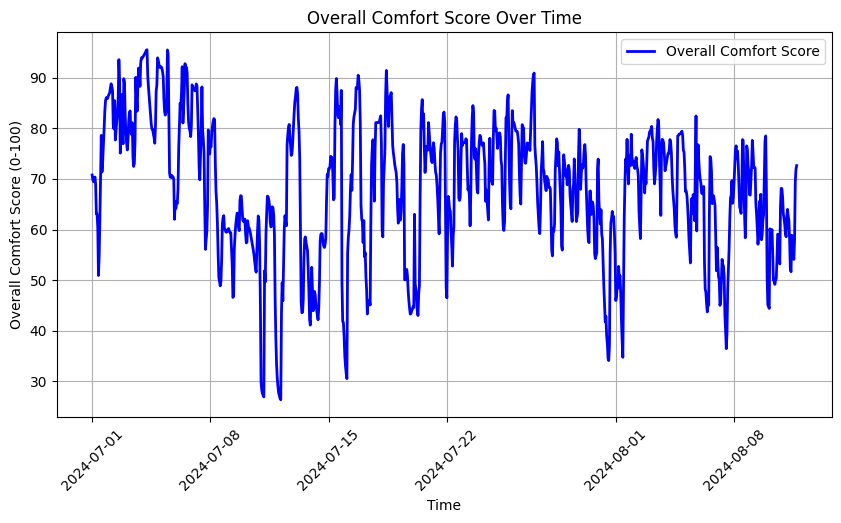

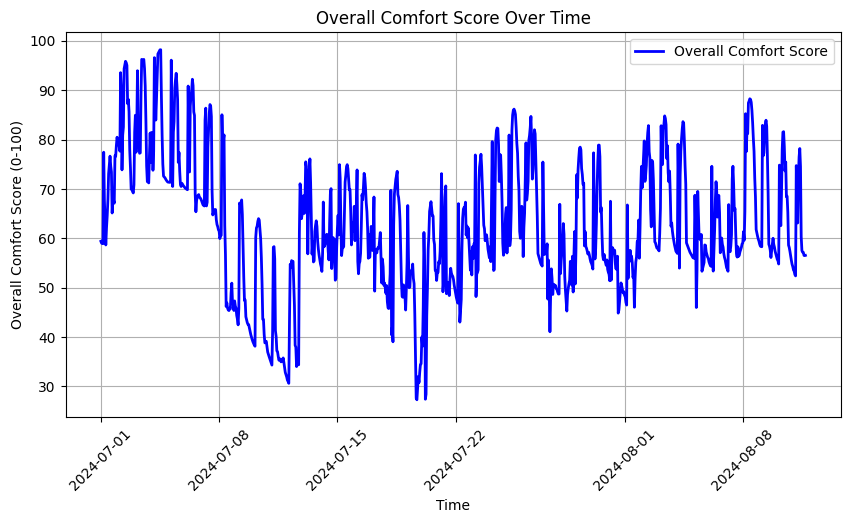

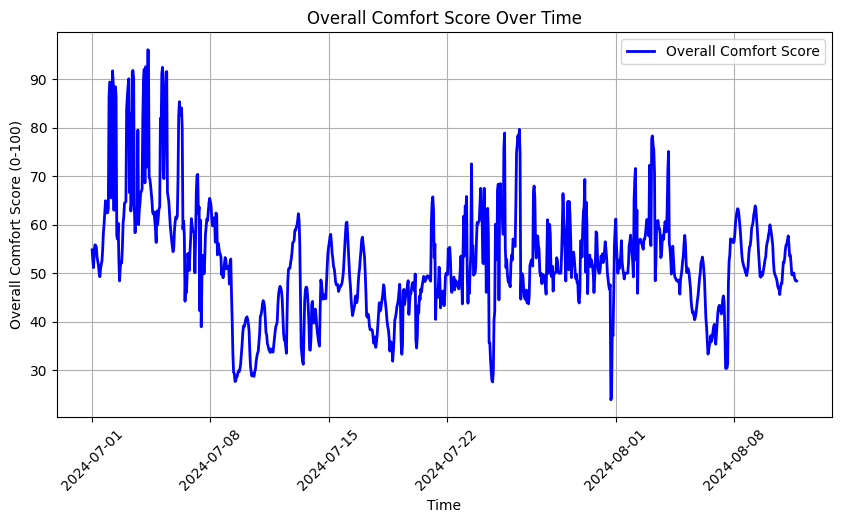

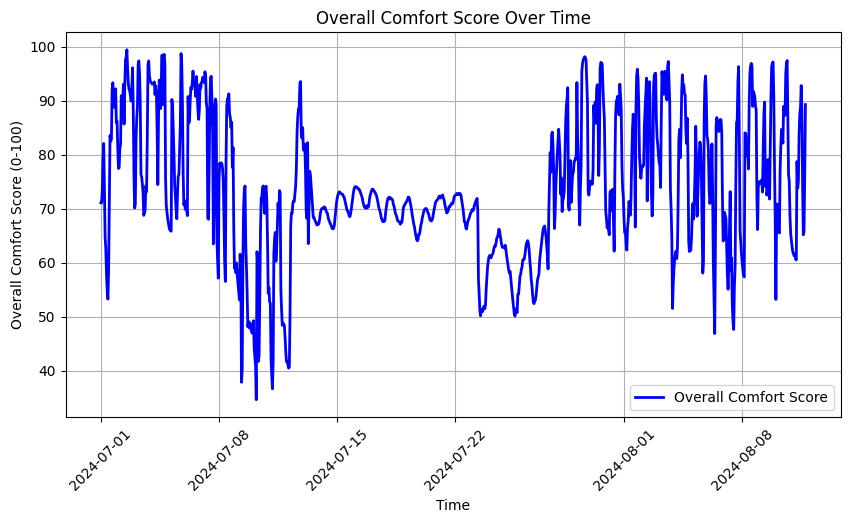

In [136]:
for df in dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_temp = df[:1000]
    plt.figure(figsize=(10, 5))
    plt.plot(df_temp['timestamp'], df_temp['Overall_Comfort'], color='blue', linewidth=2, label="Overall Comfort Score")

    plt.xlabel("Time")
    plt.ylabel("Overall Comfort Score (0-100)")
    plt.title("Overall Comfort Score Over Time")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate timestamps for readability

    # Show the plot
    plt.show()

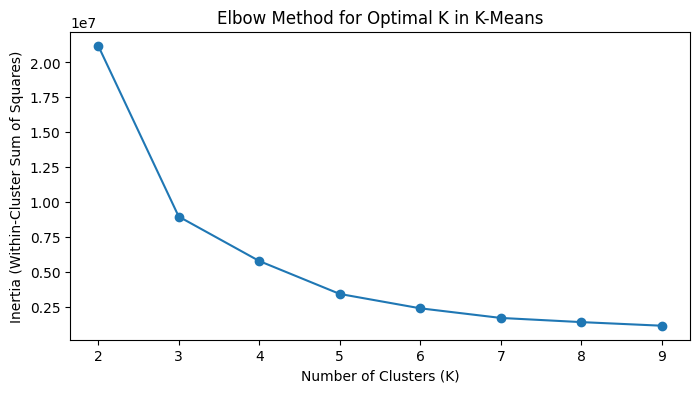

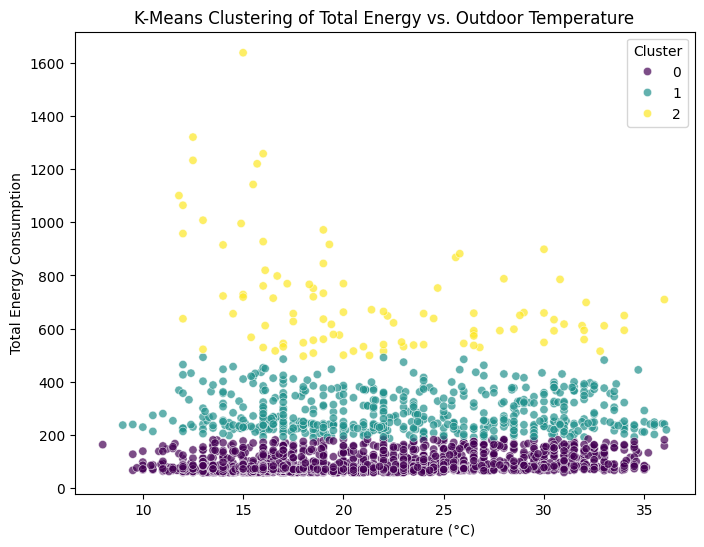

In [137]:
from sklearn.cluster import KMeans
import seaborn as sns

X = dfs[0][['total_energy', 'T_out [°C]']].dropna()  

inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K in K-Means")
plt.show()

optimal_k = 3  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
dfs[0]['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=dfs[0], x="T_out [°C]", y="total_energy", hue="cluster", palette="viridis", alpha=0.7)
plt.xlabel("Outdoor Temperature (°C)")
plt.ylabel("Total Energy Consumption")
plt.title("K-Means Clustering of Total Energy vs. Outdoor Temperature")
plt.legend(title="Cluster")
plt.show()


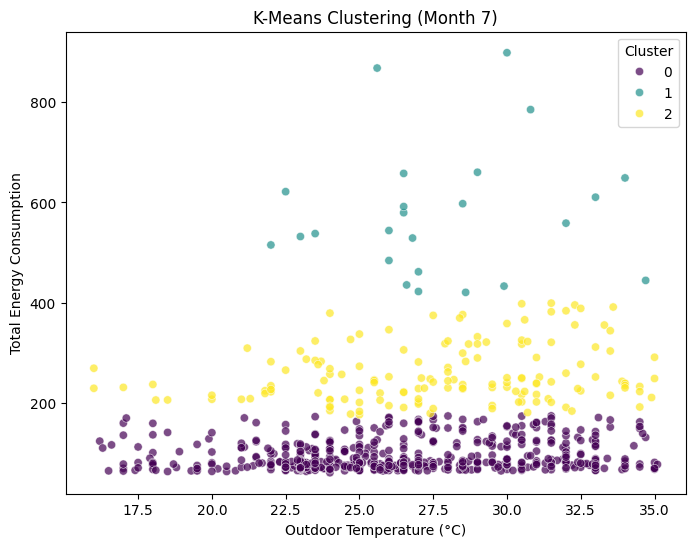

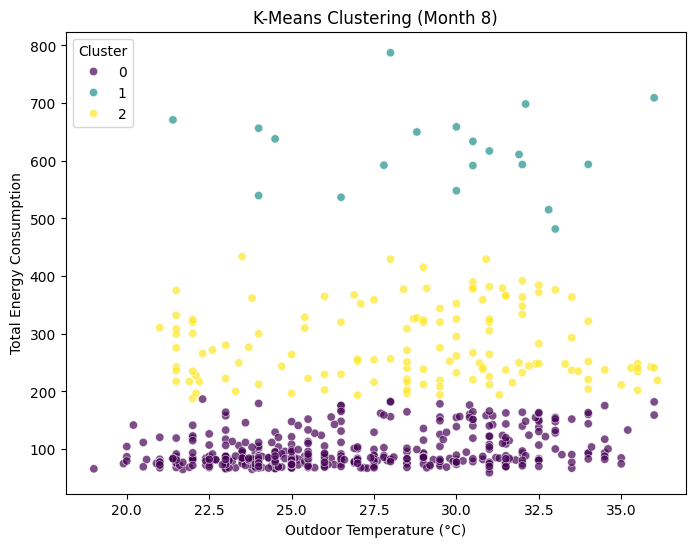

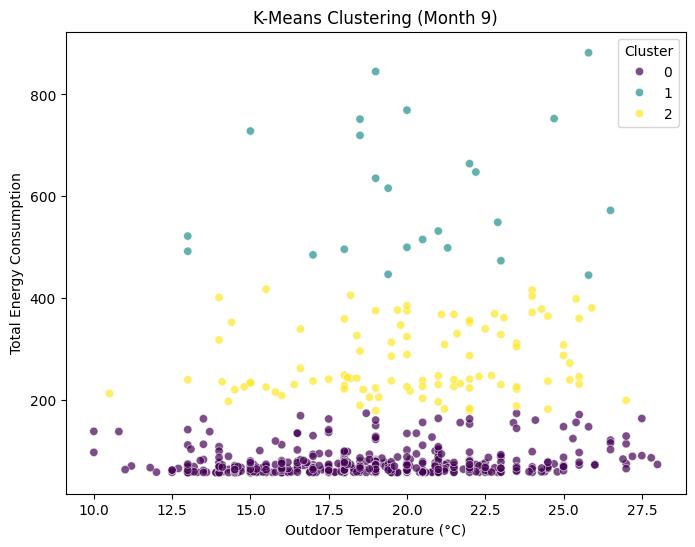

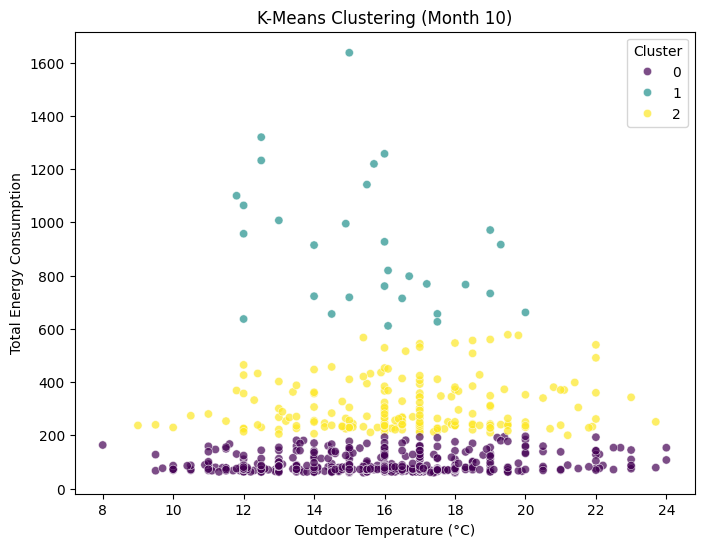

In [138]:
months = [7,8,9,10]
df = dfs[0]
for month in months:
    df['month'] = df['timestamp'].dt.month
    df_month = df[df['month'] == month].dropna(subset=['total_energy', 'T_out [°C]'])
        
    X = df_month[['total_energy', 'T_out [°C]']]

    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_month['cluster'] = kmeans.fit_predict(X)

    # Scatter plot for visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_month, x="T_out [°C]", y="total_energy", hue="cluster", palette="viridis", alpha=0.7)
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel("Total Energy Consumption")
    plt.title(f"K-Means Clustering (Month {month})")
    plt.legend(title="Cluster")
    plt.show()

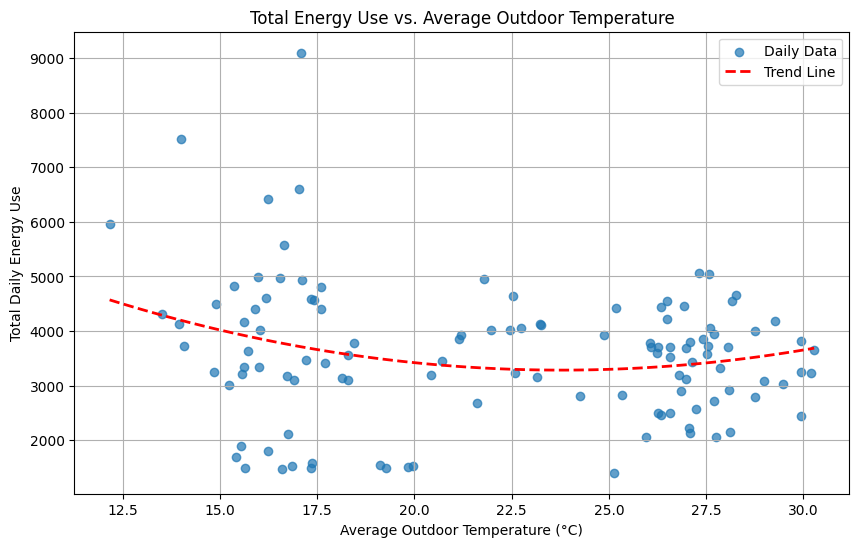

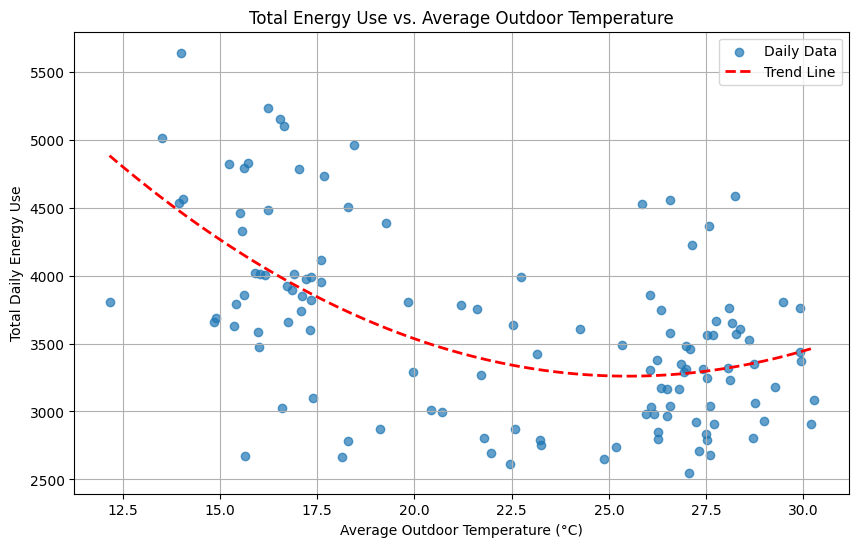

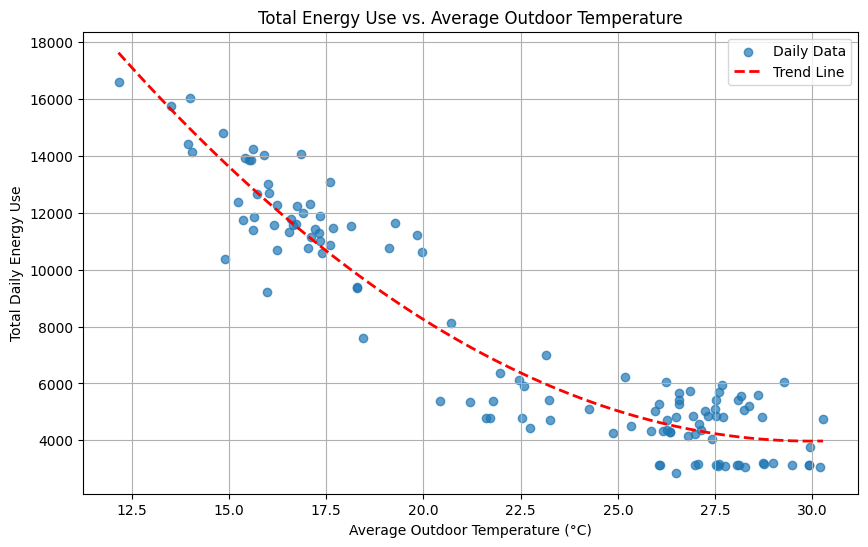

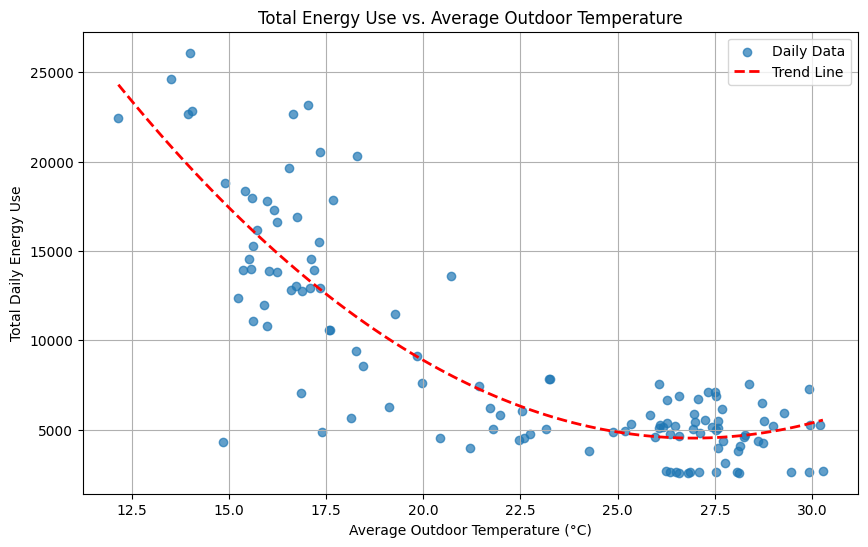

In [139]:
for df in dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    df['date'] = df['timestamp'].dt.date

    daily_data = df.groupby('date').agg(
        total_energy=('total_energy', 'sum'),
        avg_temperature=('T_out [°C]', 'mean')
    ).reset_index()

    coeffs = np.polyfit(daily_data['avg_temperature'], daily_data['total_energy'], deg=2)
    poly_eq = np.poly1d(coeffs)

    x_smooth = np.linspace(daily_data['avg_temperature'].min(), daily_data['avg_temperature'].max(), 100)
    y_smooth = poly_eq(x_smooth)

    plt.figure(figsize=(10, 6))
    plt.scatter(daily_data['avg_temperature'], daily_data['total_energy'], alpha=0.7, label='Daily Data')
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', linewidth=2, label='Trend Line')
    plt.xlabel('Average Outdoor Temperature (°C)')
    plt.ylabel('Total Daily Energy Use')
    plt.title('Total Energy Use vs. Average Outdoor Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/80], Loss: 0.3591
Epoch [2/80], Loss: 0.2224
Epoch [3/80], Loss: 0.1890
Epoch [4/80], Loss: 0.1732
Epoch [5/80], Loss: 0.1568
Epoch [6/80], Loss: 0.1479
Epoch [7/80], Loss: 0.1451
Epoch [8/80], Loss: 0.1333
Epoch [9/80], Loss: 0.1268
Epoch [10/80], Loss: 0.1120
Epoch [11/80], Loss: 0.1126
Epoch [12/80], Loss: 0.0992
Epoch [13/80], Loss: 0.1083
Epoch [14/80], Loss: 0.0976
Epoch [15/80], Loss: 0.1014
Epoch [16/80], Loss: 0.0816
Epoch [17/80], Loss: 0.0948
Epoch [18/80], Loss: 0.0866
Epoch [19/80], Loss: 0.0806
Epoch [20/80], Loss: 0.0833
Epoch [21/80], Loss: 0.0833
Epoch [22/80], Loss: 0.0759
Epoch [23/80], Loss: 0.0791
Epoch [24/80], Loss: 0.0765
Epoch [25/80], Loss: 0.0712
Epoch [26/80], Loss: 0.0735
Epoch [27/80], Loss: 0.0741
Epoch [28/80], Loss: 0.0721
Epoch [29/80], Loss: 0.0730
Epoch [30/80], Loss: 0.0591
Epoch [31/80], Loss: 0.0657
Epoch [32/80], Loss: 0.0720
Epoch [33/80], Loss: 0.0626
Epoch [34/80], Loss: 0.0657
Epoch [35/80], Loss: 0.0630
Epoch [36/80], Loss: 0.0624
E

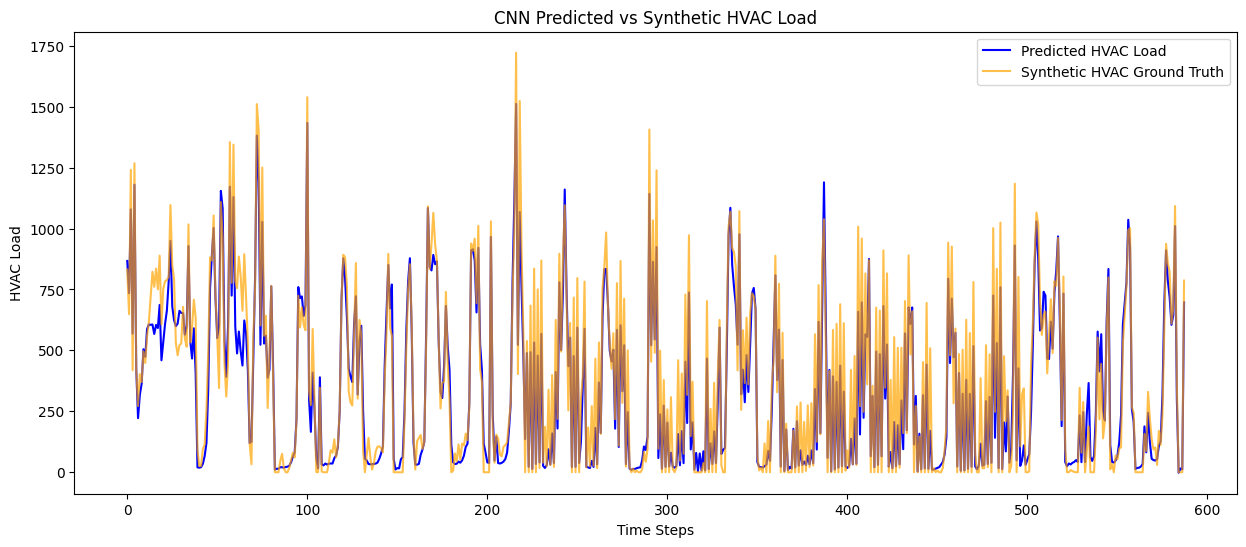

In [140]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

df = dfs[3].copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

mild_days = df[(df['T_out [°C]'] >= 20) & (df['T_out [°C]'] <= 25)]

baseline_load = mild_days.groupby(mild_days.index.hour)['total_energy'].mean()

df['baseline'] = df.index.hour.map(baseline_load)
df['synthetic_HVAC'] = (df['total_energy'] - df['baseline']).clip(lower=0)

features = df[['total_energy', 'T_out [°C]', 'T_in[°C]']]
target = df['synthetic_HVAC']

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaler = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1)).flatten()

window_size = 4
X, y = [], []
for i in range(window_size, len(features_scaled) - window_size):
    X.append(features_scaled[i-window_size:i+window_size+1])
    y.append(target_scaled[i])

X, y = np.array(X), np.array(y)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class CNN_S2P(nn.Module):
    def __init__(self):
        super(CNN_S2P, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,2), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(16, 32, kernel_size=(3,2), padding=(1,0)),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 9 * 3, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x.squeeze()


model = CNN_S2P()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model.train()
for epoch in range(60):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/80], Loss: {total_loss:.4f}")

model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
predictions = model(X_test_tensor).detach().numpy()
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(15,6))
plt.plot(predictions, label='Predicted HVAC Load', color='blue')
plt.plot(y_test_actual, label='Synthetic HVAC Ground Truth', alpha=0.7, color='orange')
plt.xlabel('Time Steps')
plt.ylabel('HVAC Load')
plt.legend()
plt.title('CNN Predicted vs Synthetic HVAC Load')
plt.show()

In [120]:
num_predictions = len(predictions)

# Get corresponding indices from the dataframe for test data
df_test_indices = df.iloc[split_idx + window_size : split_idx + window_size + num_predictions].index

# Debugging: Print lengths to verify correctness
print(f"Number of predictions: {num_predictions}")
print(f"Number of test indices: {len(df_test_indices)}")

# Ensure the lengths match exactly
assert len(df_test_indices) == num_predictions, "Mismatch between test indices and predictions length"

# Assign predictions to dataframe
print(predictions)


Number of predictions: 588
Number of test indices: 588
[ 698.12805   671.443     942.31396   500.6041   1027.3435    381.0303
  142.80452   222.9906    286.86148   470.13757   400.12375   546.72015
  544.8845    547.52765   548.6206    490.14206   524.973     513.9958
  607.39014   421.34494   489.84      569.5342    566.508     664.4554
  853.38983   626.5424    553.52234   514.0577    541.5736    598.5184
  581.04425   604.53595   473.79266   497.8772    903.18097   447.8064
  445.99255   592.80524   379.77252    36.993736   30.929413   33.631973
   52.237373   81.318665  129.88231   365.36096   696.0215    785.46655
  924.0231    662.12537   461.03622   436.7103   1064.2733    962.58356
  514.19775   304.08844   470.1823   1081.2527    595.4284   1029.3215
  580.38153   413.46802   564.9612    460.20148   380.9545    616.50946
  503.7204    332.99048   119.21761   126.41268   450.1428    644.7423
 1212.6824   1080.2373    443.76392   959.3413    498.26694   571.7724
  323.18842   35

In [119]:
df.head()

,timestamp,total_energy,CO2[ppm],PM4[ug/m3],Lighting[lux],T_in[°C],RH [%],PM10[ug/m3],PM2_5[ug/m3],PM1[ug/m3],PM0_5[ug/m3],T_out [°C],Overall_Comfort,baseline,synthetic_HVAC,predicted_HVAC
0,2024-07-01 00:00:00,103.55,856.05,56.73,0.0,28.82,47.09,56.74,56.72,56.56,49.30,24.5,71.090396,111.707447,0.000000,NaN
1,2024-07-01 01:00:00,107.17,811.66,58.76,0.0,28.95,48.63,58.77,58.75,58.58,51.07,24.0,71.082997,110.950769,0.000000,NaN
2,2024-07-01 02:00:00,114.75,884.35,59.05,0.0,27.84,46.79,59.06,59.04,58.87,51.32,22.3,73.349713,110.798148,3.951852,NaN
3,2024-07-01 03:00:00,114.24,873.47,57.12,0.0,27.03,45.17,57.13,57.10,56.94,49.64,22.0,79.253698,113.726897,0.513103,NaN
4,2024-07-01 04:00:00,107.33,849.89,55.41,0.0,26.98,45.36,55.42,55.39,55.24,48.15,21.5,82.098508,109.575167,0.000000,NaN


In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Display results
mae, rmse

(83.99864896374477, np.float64(118.24035759862619))

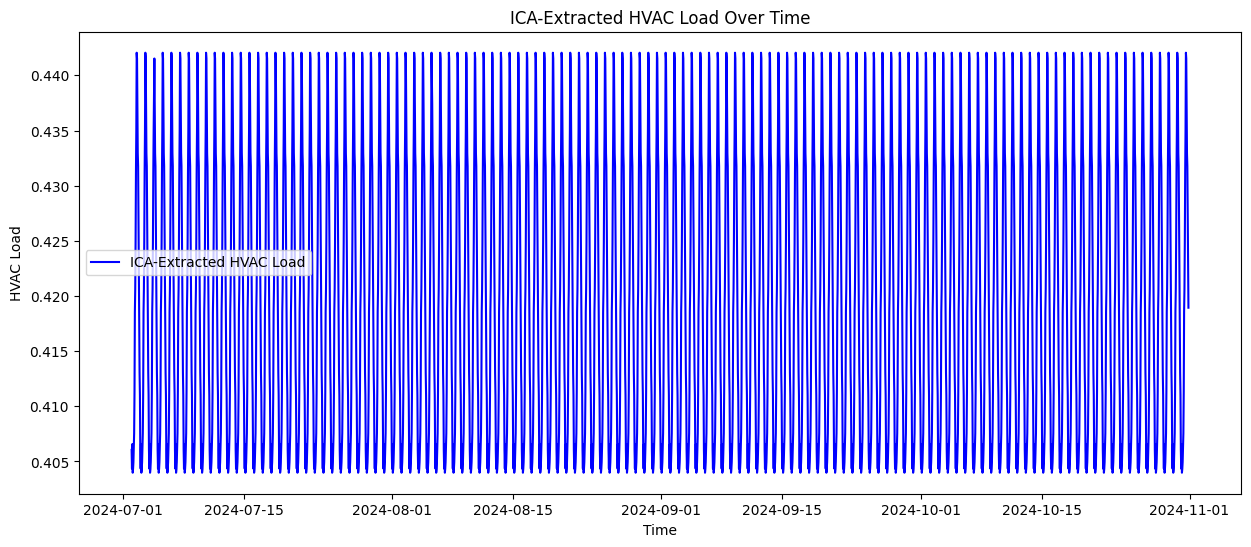

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import FastICA
# import matplotlib.pyplot as plt


# df = dfs[3].copy()
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)


# mild_days = df[(df['T_out [°C]'] >= 18) & (df['T_out [°C]'] <= 24)]
# baseline_load = mild_days.groupby(mild_days.index.hour)['total_energy'].mean()

# df['baseline'] = df.index.hour.map(baseline_load)
# df['residual_load'] = df['total_energy'] - df['baseline'] 


# window_size = 24  
# X = []
# for i in range(len(df) - window_size):
#     X.append(df['residual_load'].iloc[i: i + window_size].values) 

# X = np.array(X) 


# n_components = min(2, X.shape[1])  
# ica = FastICA(n_components=n_components, random_state=42)
# components = ica.fit_transform(X)  

# df = df.iloc[window_size:] 
# df['ICA_1'] = components[:, 0]

# if n_components > 1:
#     df['ICA_2'] = components[:, 1]
#     hvac_component = 'ICA_1' if abs(df['ICA_1'].corr(df['T_out [°C]'])) > abs(df['ICA_2'].corr(df['T_out [°C]'])) else 'ICA_2'
# else:
#     hvac_component = 'ICA_1'

# df['HVAC_ICA'] = df[hvac_component].clip(lower=0)  

# hourly_hvac_bounds = df.groupby(df.index.hour)['HVAC_ICA'].mean()
# df['HVAC_ICA'] = df.index.hour.map(hourly_hvac_bounds)  

# plt.figure(figsize=(15, 6))
# plt.plot(df.index, df['HVAC_ICA'], label='ICA-Extracted HVAC Load', color='blue')
# plt.xlabel('Time')
# plt.ylabel('HVAC Load')
# plt.legend()
# plt.title('ICA-Extracted HVAC Load Over Time')
# plt.show()


C:\Users\Kelsier\AppData\Local\Temp\ipykernel_18868\1714498928.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_month['HVAC_ICA'] = df_last_month[hvac_component].clip(lower=0)
C:\Users\Kelsier\AppData\Local\Temp\ipykernel_18868\1714498928.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_month['HVAC_ICA_Scaled'] = df_last_month['HVAC_ICA'] * (hvac_avg_ratio * df_last_month['total_energy'].mean())


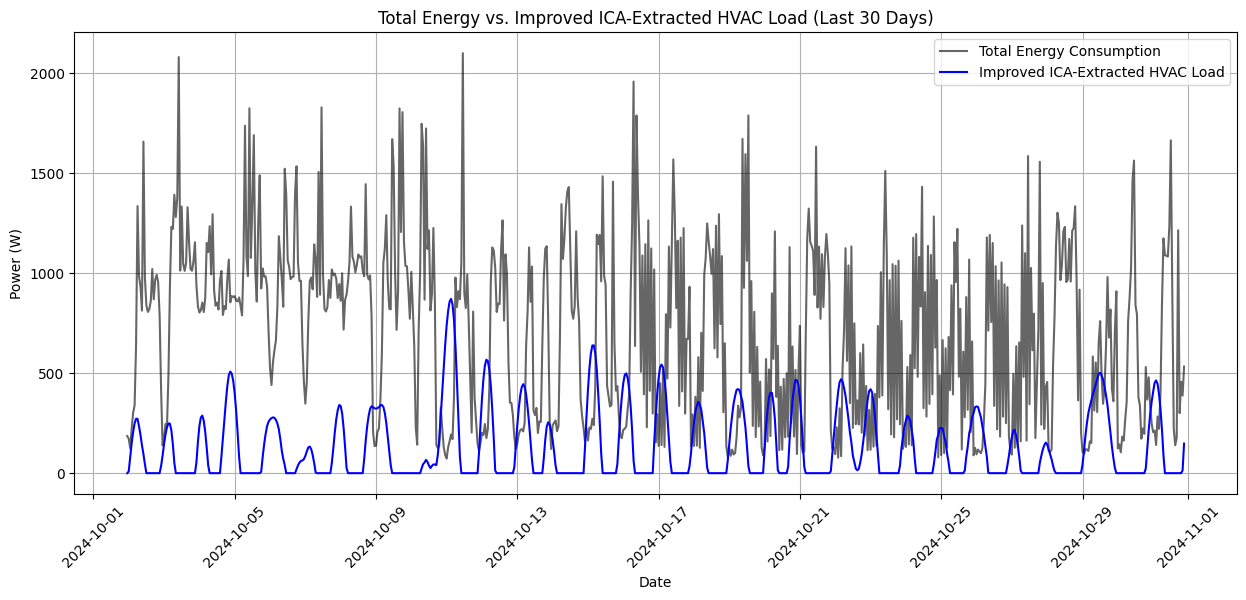

In [ ]:
# df = df.iloc[window_size:] 

# df_last_month = df.iloc[-30*24:]  

# fft_ica1 = np.fft.fft(df_last_month['ICA_1'])
# fft_ica2 = np.fft.fft(df_last_month['ICA_2']) if 'ICA_2' in df_last_month else None

# hvac_component = 'ICA_1'
# if fft_ica2 is not None and np.abs(fft_ica2[24]).sum() > np.abs(fft_ica1[24]).sum():
#     hvac_component = 'ICA_2'

# df_last_month['HVAC_ICA'] = df_last_month[hvac_component].clip(lower=0)

# hvac_avg_ratio = 0.4  
# df_last_month['HVAC_ICA_Scaled'] = df_last_month['HVAC_ICA'] * (hvac_avg_ratio * df_last_month['total_energy'].mean())

# plt.figure(figsize=(15, 6))
# plt.plot(df_last_month.index, df_last_month['total_energy'], label='Total Energy Consumption', color='black', alpha=0.6)
# plt.plot(df_last_month.index, df_last_month['HVAC_ICA_Scaled'], label='Improved ICA-Extracted HVAC Load', color='blue')

# plt.xlabel('Date')
# plt.ylabel('Power (W)')
# plt.title('Total Energy vs. Improved ICA-Extracted HVAC Load (Last 30 Days)')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid()

# plt.show()

C:\Users\Kelsier\AppData\Local\Temp\ipykernel_18868\462830907.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['filtered_energy'].interpolate(inplace=True)
C:\Users\Kelsier\AppData\Local\Temp\ipykernel_18868\462830907.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter

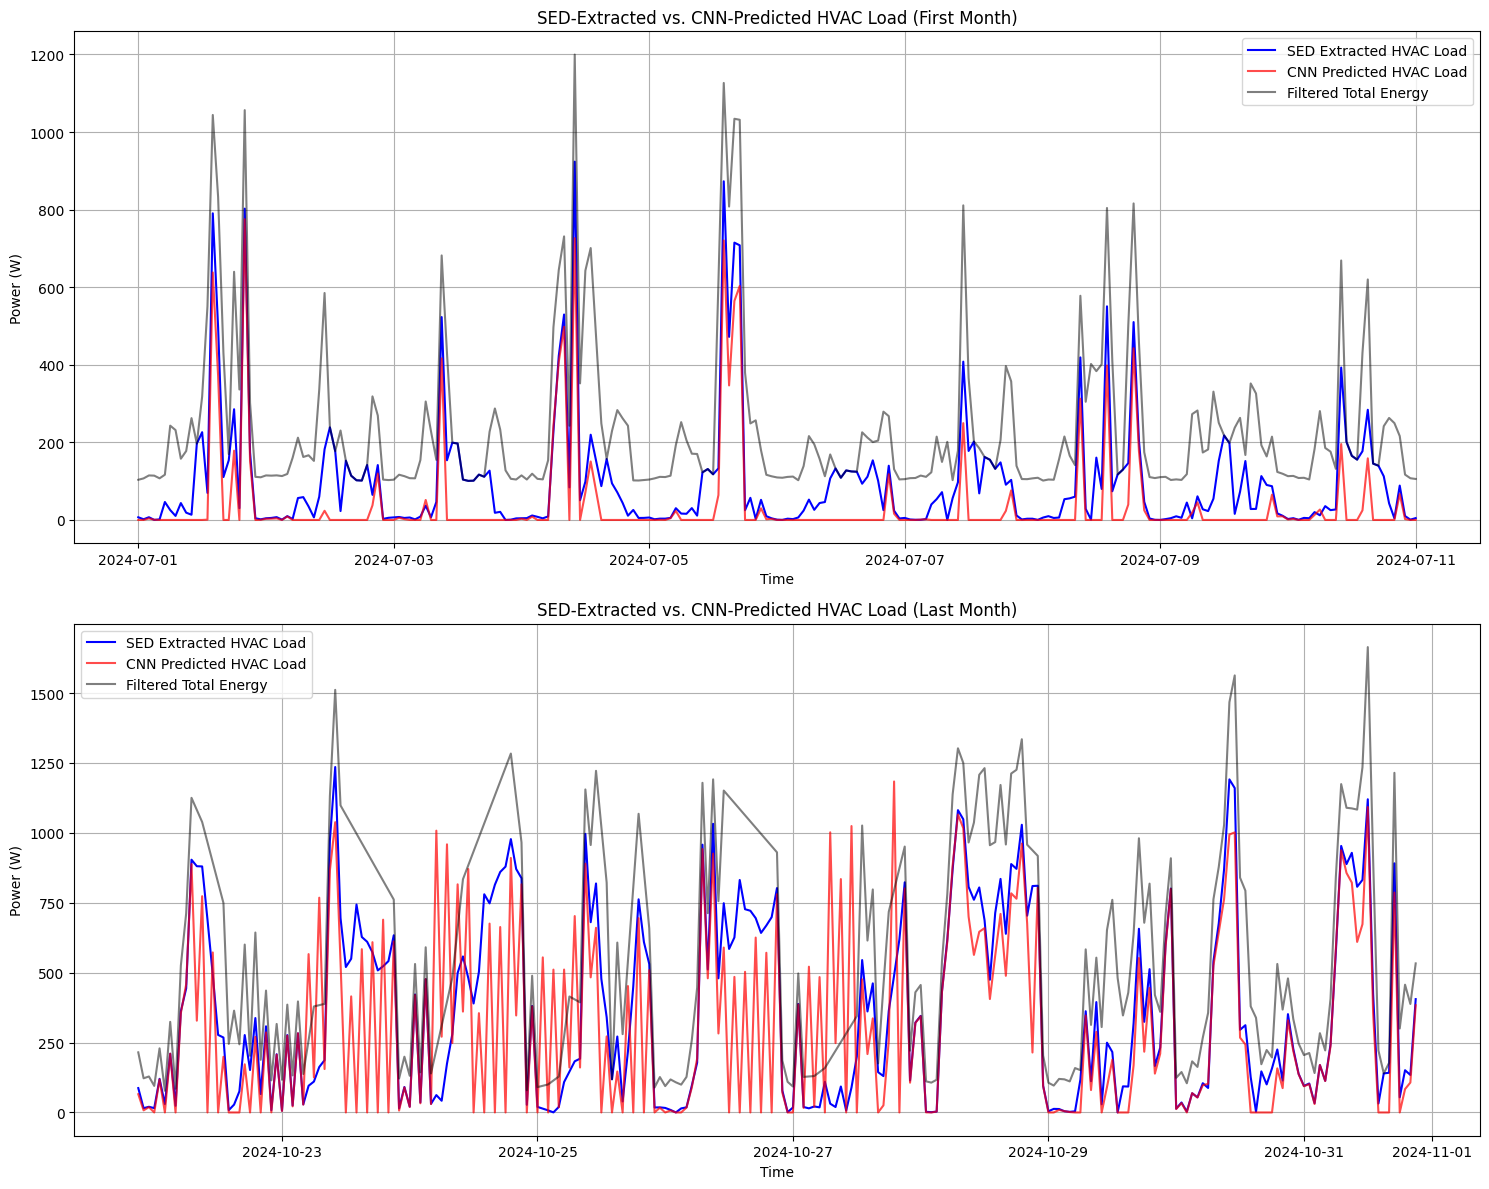

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df2 = df
# df2['timestamp'] = pd.to_datetime(df2['timestamp'])
# df2.set_index('timestamp', inplace=True)

def detect_large_loads(df2, rise_threshold=500, drop_threshold=500, duration=2):
    df2['load_change'] = df2['total_energy'].diff().abs()
    df2['is_large_load'] = (df2['load_change'] > rise_threshold) & (df2['load_change'].shift(-duration) > drop_threshold)
    df2['filtered_energy'] = np.where(df2['is_large_load'], np.nan, df2['total_energy'])
    df2['filtered_energy'].interpolate(inplace=True)
    return df

df2 = detect_large_loads(df2)

mild_threshold_low = 20  
mild_threshold_high = 25

df2['day_type'] = 'mild'
df2.loc[df2['T_out [°C]'] < mild_threshold_low, 'day_type'] = 'cold'
df2.loc[df2['T_out [°C]'] > mild_threshold_high, 'day_type'] = 'hot'

df_filtered = df2.loc[~((df2.index >= '2024-07-13') & (df2.index <= '2024-07-28'))]

df_filtered['hour'] = df_filtered.index.hour  
df2['hour'] = df2.index.hour  


mild_avg = df_filtered[df_filtered['day_type'] == 'mild'].groupby('hour')['filtered_energy'].median()
hot_avg = df_filtered[df_filtered['day_type'] == 'hot'].groupby('hour')['filtered_energy'].median()
cold_avg = df_filtered[df_filtered['day_type'] == 'cold'].groupby('hour')['filtered_energy'].median()


df2['mild_avg'] = df2['hour'].map(mild_avg)
df2['hot_avg'] = df2['hour'].map(hot_avg)
df2['cold_avg'] = df2['hour'].map(cold_avg)


df2['HVAC_cooling'] = np.maximum(0, df2['filtered_energy'] - df2['mild_avg'])
df2['HVAC_heating'] = np.maximum(0, df2['mild_avg'] - df2['filtered_energy'])  

df2['HVAC_total'] = df2['HVAC_cooling'] + df2['HVAC_heating']

df2['HVAC_total'] = np.minimum(df['HVAC_total'], df['filtered_energy'])

fig, axes = plt.subplots(2, 1, figsize=(15,12))

first_month = df2.loc[df.index.min():df2.index.min() + pd.DateOffset(days=10)]
axes[0].plot(first_month.index, first_month['HVAC_total'], label='SED Extracted HVAC Load', color='blue')
axes[0].plot(first_month.index, first_month['synthetic_HVAC'], label='CNN Predicted HVAC Load', color='red', alpha=0.7)
axes[0].plot(first_month.index, first_month['filtered_energy'], label='Filtered Total Energy', color='black', alpha=0.5)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Power (W)')
axes[0].legend()
axes[0].set_title('SED-Extracted vs. CNN-Predicted HVAC Load (First Month)')
axes[0].grid()

last_month = df2.loc[df.index.max() - pd.DateOffset(days=10):df.index.max()]
axes[1].plot(last_month.index, last_month['HVAC_total'], label='SED Extracted HVAC Load', color='blue')
axes[1].plot(last_month.index, last_month['synthetic_HVAC'], label='CNN Predicted HVAC Load', color='red', alpha=0.7)
axes[1].plot(last_month.index, last_month['filtered_energy'], label='Filtered Total Energy', color='black', alpha=0.5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Power (W)')
axes[1].legend()
axes[1].set_title('SED-Extracted vs. CNN-Predicted HVAC Load (Last Month)')
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
assert len(predictions) == len(y_test_actual)

[ 876.538      729.7634    1082.2616     559.68304   1172.0795
  452.18942    232.60526    270.55115    308.7336     492.15555
  449.1211     620.7449     619.83856    650.6548     649.4803
  565.25116    633.74756    599.2636     717.8724     464.54556
  544.4608     613.55365    652.3993     756.91473    957.9908
  695.43256    648.0759     585.9444     601.4005     670.6253
  659.7649     665.20795    557.992      564.41327    947.6034
  541.4305     511.98465    594.5569     399.2442      40.024822
   22.66146     30.704685    51.08129     76.37232    143.33708
  380.81323    780.1874     866.6399    1020.2347     717.07043
  524.0495     507.23416   1096.3032     954.1254     541.9724
  340.32645    450.55484   1139.8859     651.2919    1156.1469
  655.4412     528.01843    610.96136    469.5781     388.79678
  671.48175    554.2326     406.96768    143.20709    139.30438
  443.71823    696.1209    1299.2898    1125.5654     508.06033
 1041.1877     544.5635     625.5965     342.3